### LSTM 101 
- The aim of this notebook is to break down an LSTM on a simple regression problem where one is trying to predict the value of a variable at t+1.
- The LSTM module is explicitly coded out for verbosity and you are able to change the params to adjust and see how it works. 
- There are some derivations of simples passes through the LSTM network to show how its calculating network values from first principles.

In [1]:
!pwd

/Users/ds423/git_uni/sequence-modelling-101/notebooks


In [2]:
import os
import glob
import random
import json

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from progressbar import ProgressBar

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from torchvision import models, transforms
import torchvision.transforms as transforms

# seqmod package imports
from src.utils import set_seed, add_metric_plot
from src.dataset import StormWindSpeedSequencedDataset

/var/folders/1k/vm_h9ycj6d9020w63h786g5w0000gp/T/ipykernel_29964/2428810536.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
SEED = 42
set_seed(42)

print(f"SEED = {SEED}")

SEED = 42


In [4]:
DEVICE = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    DEVICE = 'cuda'
else:
    print("No GPU available!")

DEVICE

No GPU available!


'cpu'

In [5]:
# create a dummy dataset to just check that its working.
dummy = StormWindSpeedSequencedDataset(data_root_dir='../data/',
                                       storms_to_exclude=['ztb'], 
                                       storm_name=None,
                                       numeric_cols=["relative_time", "wind_speed"],
                                       time_column="relative_time",
                                       dt=1800,
                                       input_sequence_length=3,
                                       target_length=1,
                                       data_split=None,
                                       data_splits=None,
                                       transform=None,
                                       random_seed=SEED,
                                       )


A, B, C = dummy.__getitem__(0)
A, B, C

print(f"Metadata = {A}\n")
print(f"Inputs --> {B.shape} --> \n{B}\n")
print(f"Targets --> {C.shape} --> \n{C}\n")

Metadata = ('gme', '1')

Inputs --> torch.Size([3, 2]) --> 
tensor([[ 0., 30.],
        [ 1., 30.],
        [ 2., 30.]])

Targets --> torch.Size([1, 2]) --> 
tensor([[ 3., 30.]])



### Comments:
Link: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ 
- It is intentional to produce the “feature” and the “target” the same shape: For a window of three time steps, the “feature” is the time series from t to t+2 and the target is from 
t+1 to t+3. What we are interested is t+3 but the information of to is useful in training.
- For y_pred,  extract only the data from the last time step as y_pred[:, -1, :]

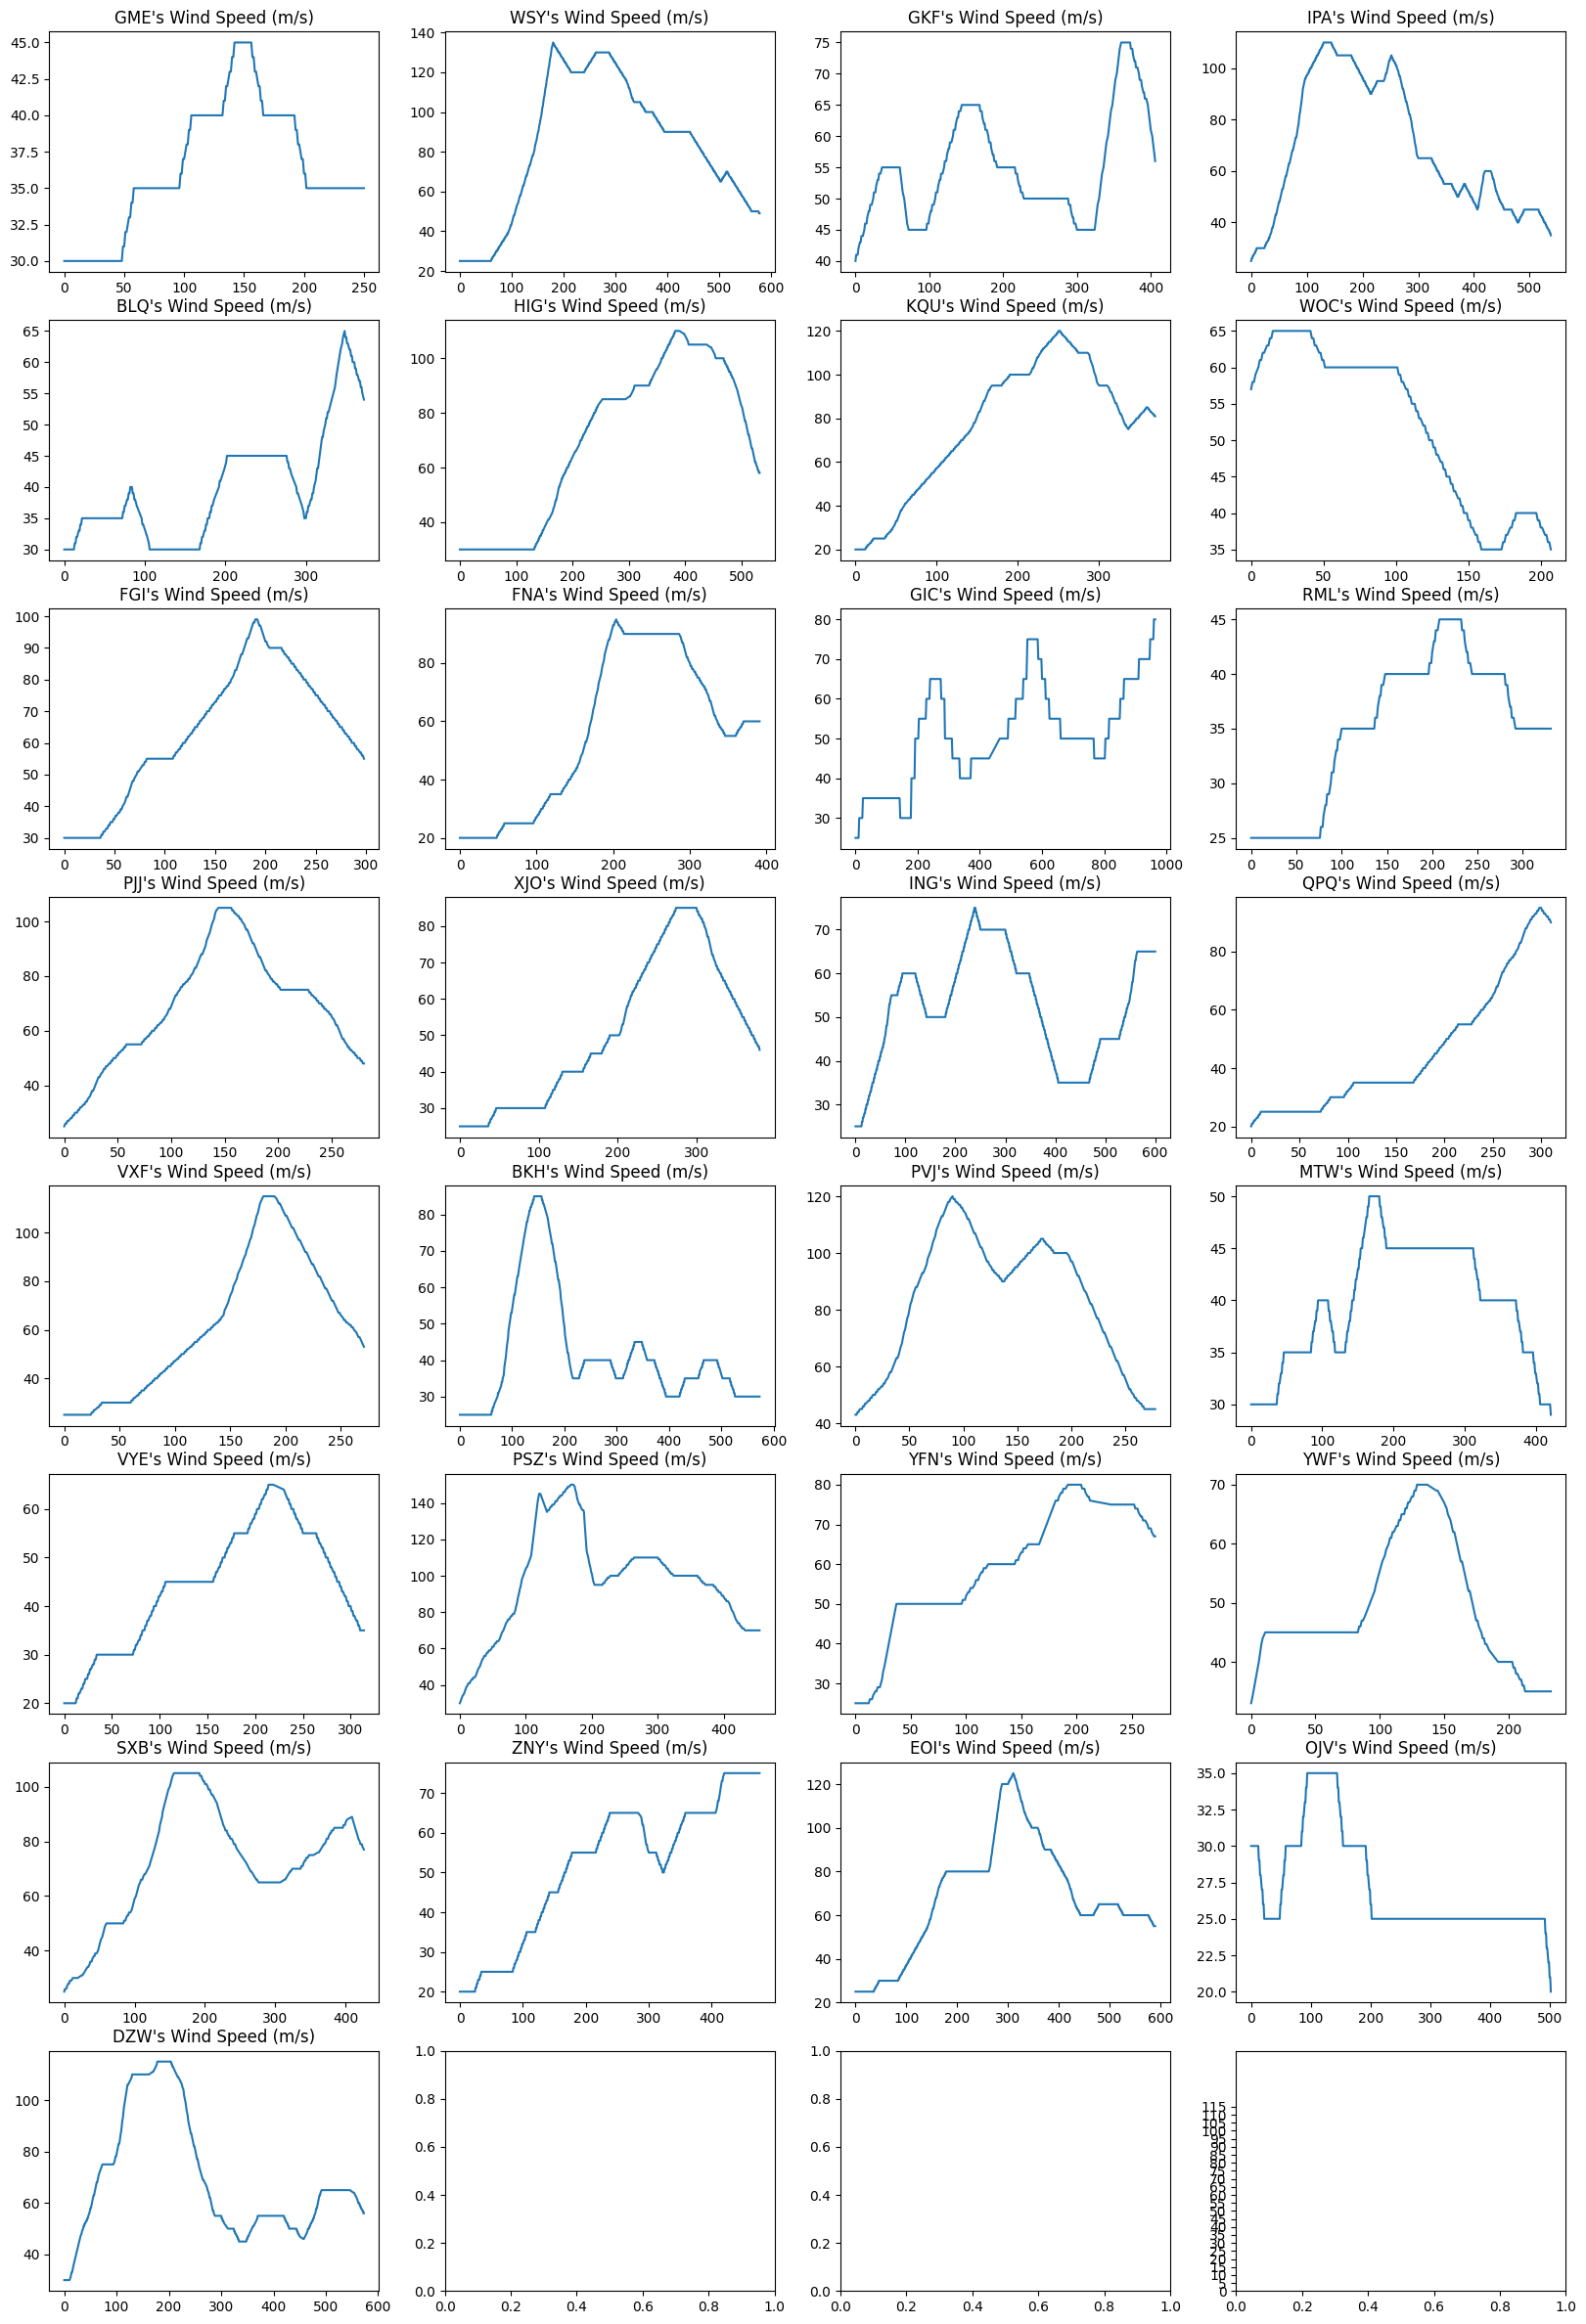

In [6]:
# plotting the storm wind speed (m/s) time series
_df = dummy.df

row_length = 4
fig, axs = plt.subplots(nrows=8 , ncols=row_length, figsize=(20, 30))
for e, i in enumerate(dummy.storm_names):
     x, y = _df[_df.storm_id == i].dt, _df[_df.storm_id == i].wind_speed
     axs[(e // row_length), e%4].plot(x, y)
     axs[(e // row_length), e%4].set_title(f"{i.upper()}'s Wind Speed (m/s)", fontsize=12)
     plt.yticks(range(0, y.max() + 1, 5))

In [7]:
DATA_ROOT_DIR = '../data/'
TEST_STORM = 'ztb'
STORM_NAME = 'eoi'
NUMERIC_COLS = ["relative_time", "wind_speed"]
TIME_COLUMN = "relative_time"
DT = 1800
INPUT_SEQUENCE_LENGTH = 3
TARGET_SEQUENCE_LENGTH = 1

DATA_SPLIT = (0.8, 0.2, 0.2)

print("\n\n\t\t#### DATASET INFO ####\n")
print(f"\t--> DATA ROOT DIR = {DATA_ROOT_DIR}")
print(f"\t--> TEST STORM = {TEST_STORM}")
print(f"\t--> TRAINING STORM = {STORM_NAME}")
print(f"\t--> NUMERIC COLUMNS = {NUMERIC_COLS}")
print(f"\t--> TIME COLUMN = {TIME_COLUMN}")
print(f"\t--> DT = {DT}")
print(f"\t--> INPUT SEQUENCE LENGTH = {INPUT_SEQUENCE_LENGTH}")
print(f"\t--> TARGET SEQUENCE LENGTH = {TARGET_SEQUENCE_LENGTH}")
print(f"\t--> DATA SPLIT = {DATA_SPLIT}")



		#### DATASET INFO ####

	--> DATA ROOT DIR = ../data/
	--> TEST STORM = ztb
	--> TRAINING STORM = eoi
	--> NUMERIC COLUMNS = ['relative_time', 'wind_speed']
	--> TIME COLUMN = relative_time
	--> DT = 1800
	--> INPUT SEQUENCE LENGTH = 3
	--> TARGET SEQUENCE LENGTH = 1
	--> DATA SPLIT = (0.8, 0.2, 0.2)


In [8]:
train_dataset = StormWindSpeedSequencedDataset(data_root_dir=DATA_ROOT_DIR,
                                               storms_to_exclude=[TEST_STORM], 
                                               storm_name=STORM_NAME,
                                               numeric_cols=NUMERIC_COLS,
                                               time_column=TIME_COLUMN,
                                               dt=DT,
                                               input_sequence_length=INPUT_SEQUENCE_LENGTH,
                                               target_length=TARGET_SEQUENCE_LENGTH,
                                               data_split="train",
                                               data_splits=DATA_SPLIT,
                                               transform=None,
                                               random_seed=SEED,
                                               )


val_dataset = StormWindSpeedSequencedDataset(data_root_dir=DATA_ROOT_DIR,
                                             storms_to_exclude=[TEST_STORM], 
                                             storm_name=STORM_NAME,
                                             numeric_cols=NUMERIC_COLS,
                                             time_column=TIME_COLUMN,
                                             dt=DT,
                                             input_sequence_length=INPUT_SEQUENCE_LENGTH,
                                             target_length=TARGET_SEQUENCE_LENGTH,
                                             data_split="val",
                                             data_splits=DATA_SPLIT,
                                             transform=None,
                                             random_seed=SEED,
                                             )


print("\n\n\t\t#### TENSOR INFO ####\n")
print(f"\t --> Train Dataset: {train_dataset.__len__()} | dims: {train_dataset.data.shape}")
print(f"\t --> Validation Dataset: {val_dataset.__len__()} | dims: {val_dataset.data.shape} ")



		#### TENSOR INFO ####

	 --> Train Dataset: 310 | dims: (310, 10)
	 --> Validation Dataset: 78 | dims: (78, 10) 


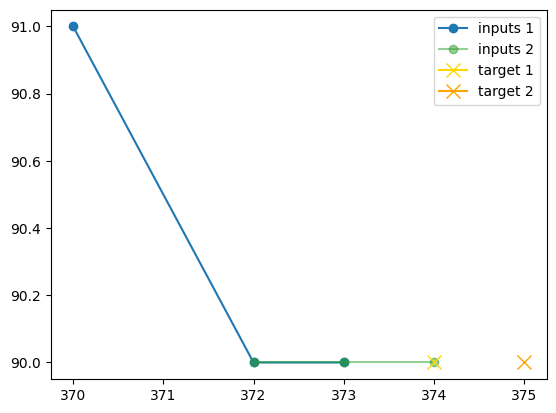

In [9]:
# lets plot 
ts = np.array(train_dataset.data[len(train_dataset.data)-2:].iloc[:, 2:2+4], dtype=np.int32)
vs = np.array(train_dataset.data[len(train_dataset.data)-2:].iloc[:, 2+4:], dtype=np.int32)

fig, ax = plt.subplots()

ax.plot(ts[0][:-1], vs[0][:-1], color='C0', marker='o', label='inputs 1')
ax.plot(ts[1][:-1], vs[1][:-1], color='C2', marker='o', label='inputs 2', alpha=0.5)
ax.plot(ts[0][-1:], vs[0][-1:], color='gold', marker='x', markersize=10, label='target 1')
ax.plot(ts[1][-1:], vs[1][-1:], color='orange', marker='x', markersize=10, label='target 2')

ax.legend(loc='best')

In [10]:
BATCH_SIZE = 1
NUM_WORKERS = 0

print("\n\n\t\t#### DATALOADER INFO ####\n")
print(f"\t--> BATCH SIZE = {BATCH_SIZE}")
print(f"\t--> NUM WORKERS = {NUM_WORKERS}")



		#### DATALOADER INFO ####

	--> BATCH SIZE = 1
	--> NUM WORKERS = 0


In [11]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=False)

print("\n\n\t\t#### DATA LOADER INFO ####\n")
print(f"\t --> Train Dataloader: {train_loader.dataset.__len__()} | batch size: {train_loader.batch_size}")
print(f"\t --> Validation Dataset: {val_loader.dataset.__len__()} | batch size: {val_loader.batch_size} ")



		#### DATA LOADER INFO ####

	 --> Train Dataloader: 310 | batch size: 1
	 --> Validation Dataset: 78 | batch size: 1 


tensor([[286., 288., 289.]]) tensor([[118., 120., 120.]])
tensor([[290.]]) tensor([[120.]])


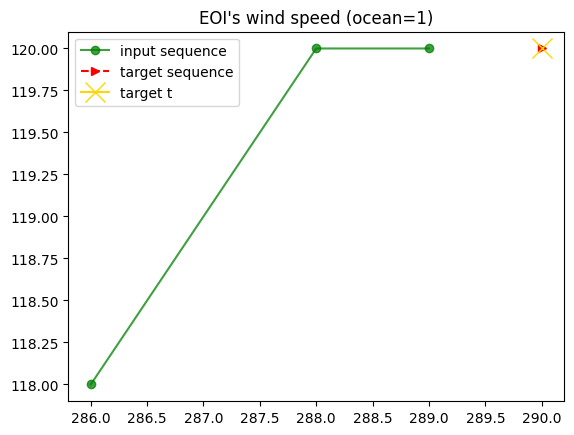

In [12]:
# plot a batch
train_batch = next(iter(train_loader))
batch_meta_data, batch_inputs, batch_targets = train_batch

batch_num = 0
batch_ts, batch_vs = batch_inputs[:, :, 0], batch_inputs[:, :, 1]
batch_ts_target, batch_vs_target = batch_targets[:, :, 0], batch_targets[:, :, 1]

print(batch_ts, batch_vs)
print(batch_ts_target ,batch_vs_target)

fig, ax = plt.subplots()
ax.plot(batch_ts[batch_num], batch_vs[batch_num], 'go-', label='input sequence', zorder=1, alpha=0.75)
ax.plot(batch_ts_target[batch_num], batch_vs_target[batch_num], 'r>--', label='target sequence', zorder=0, alpha=1)
ax.plot(batch_ts_target[batch_num][-1], batch_vs_target[batch_num][-1], color='gold', marker='x', markersize=15, label='target t', zorder=2)

ax.set_title(f"{batch_meta_data[0][batch_num].upper()}'s wind speed (ocean={batch_meta_data[1][batch_num]})")
ax.legend(loc='best')

### MODELLING

#### LSTM Cell

In [13]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True, _print=True):
        """Initialize the LSTMCell module.

        Parameters
        ----------
        input_size : int
            The number of expected features in the input `x` (The number of features for each element of the input sequence).
        hidden_size : int
            The number of features in the hidden state `h`.
        bias : bool, optional
            If `True`, bias weights (`b_ih` and `b_hh`) will be included in the LSTM cell calculations. Default is `True`.

            b_ih = biases of the input2hidden layer, b_hh = biases of the hidden2hidden layer.
        _print : bool, optional
            A flag to control printing for debugging or logging purposes. Default is `True`.
        """

        super(LSTMCell, self).__init__()

        # seeded for reproducibility.
        set_seed(SEED)

        # inputs
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.print = _print

        # create a linear layer to map from input to hidden space
        self.input2hidden = nn.Linear(in_features=input_size,
                                      out_features=(hidden_size * 4),  # hidden*4 for input gate, forget gate, output gate, candidate update
                                      bias=bias)

        # create a linear layer to map from previous hidden to current hidden space
        self.hidden2hidden = nn.Linear(in_features=hidden_size,
                                       out_features=(hidden_size * 4),
                                       bias=bias)

        # initialise the weights (and biases) of the input2hidden and hidden2hidden layers.
        self.initialise_parameters()

    def initialise_parameters(self):
        """Initialise the weights and biases with a unform dist [-std, std].
        
        Uniform bounds (std): [-sqrt(1/hidden_size), sqrt(1/hidden_size)] (pytorch implementation).
        """
        std = (1 / np.sqrt(self.hidden_size))
        for p in self.parameters():  # .parameters() = weights + biases
            # number of weights (or biases) = input_size * 4 (4 for each op.)
            p.data.uniform_(-std, std)  

    def forward(self, i, h, c):
        """Forward pass through LSTM cell. 
        
        The 1st layer cell inputs will be [c_t = _cell_state(t-1) || h_t = _hidden_state(t-1) || i_t = _input_state].
        Cells in layers > 1 will take in [c_t = _cell_state(t-1) || h_t = _hidden_state(t-1) || i_t = _hidden_state (layer-1)].
        """
        if self.print:
            print("-------------------------------------------------------------------")
            print(f"LSTM Cell Inputs:")
            print(f"\ti = {i}")
            print(f"\th = {h}")
            print(f"\tc = {c}\n")

        # bottom left of the LSTM cell (diagram). This is adding input i(t) with h(t-1)
        # gates will be a 1D tensor, 4*input_size
        gates = self.input2hidden(i) + self.hidden2hidden(h) # apply the weights to both input and previous state
        
        if self.print:
            print(f"i2h = {self.input2hidden(i)}")
            print(f"h2h = {self.hidden2hidden(h)}")
            print(f"LSTM Cell in --> i_t + h_t-1:")
            print(f"\ti_t + h_t-1 = {gates}\n")
        
        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, dim=1) # separate the output into each of the LSTM operations

        if self.print:
            print("LSTM Cell Gate Inputs:")
            print(f"\tinput gate = {input_gate}")
            print(f"\tforget gate = {forget_gate}")
            print(f"\tcandidate update = {candidate_update}")
            print(f"\toutput update = {output_gate}\n")

        # apply the corresponding activations
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        cd_t = torch.tanh(candidate_update)
        o_t = torch.sigmoid(output_gate)

        # calculate the next cell state
        c_t = (f_t * c) + (i_t * cd_t)

        # calculate the next hidden state
        h_t = o_t * torch.tanh(c_t)

        if self.print:
            print("LSTM Cell Gate Outputs:")
            print(f"\tinput gate = {i_t}")
            print(f"\tforget gate = {f_t}")
            print(f"\tcandidate update = {c_t}")
            print(f"\toutput update = {o_t}\n")

            print("LSTM Cell Outputs:")
            print(f"\tc_t = {c_t}")
            print(f"\th_t = {h_t}\n\n")

            print("-------------------------------------------------------------------")

        return h_t, c_t 

#### LSTM

In [14]:
class LSTM(nn.Module):
    """LSTM module.

        Parameters
        ----------
        input_sequence_length : int
            The length of the input sequences. Determines how many LSTM cells are in each of the layers. 1 cell per element in sequence. Each element can have N features.
        input_size : int
            The number of expected features in the input `x` (The number of features for each element of the input sequence).
        hidden_size : int
            The number of features in the hidden state `h`.
        num_layers : int
            Number of recurrent layers. E.g., `num_layers=2` would mean stacking two LSTMs together to form a 'stacked LSTM',
            with the second LSTM taking in outputs of the first LSTM and computing the final results. An LSTM here is given to 
            N number of LSTM cells determined by the input sequence length, N. 
        output_size : int
            The size of the output, typically the size of the last layer that outputs the predictions.
        device : torch.device
            The device (CPU or GPU) on which the LSTM will be running.
        bias : bool, optional
            If `False`, then the layer does not use bias weights `b_ih`, `b_hh` and `bho. Default is `True`.

            b_ih = biases of the input2hidden layer, b_hh = biases of the hidden2hidden layer and b_ho = biases of the hidden2output layer.
        _print : bool, optional
            A flag to control printing for debugging or logging purposes, defaulting to `True`.
        """
    def __init__(self, input_sequence_length, input_size, hidden_size, num_layers, output_size, device, bias=False, _print=True):
        """Initialisation."""
        super(LSTM, self).__init__()

        set_seed(SEED)

        self.input_sequence_length = input_sequence_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        self.device = device
        self.print = _print

        # create a list of lstm cell modules
        self.lstm_cell_list = nn.ModuleList()

        # create each layer in the network
        for l in range(self.num_layers):
            if self.print:    print(f"Adding LSTM Cell (layer) {l}...")
            _cell = LSTMCell(input_size=(self.input_size if l == 0 else self.hidden_size),  # 1st layer has to have same inputs as input to connect the FNN. 
                             hidden_size=self.hidden_size,
                             bias=self.bias,
                             _print=self.print,
                             )
            self.lstm_cell_list.append(_cell)

        # create a final linear layer from hidden state to network output
        self.hidden2output = nn.Linear(in_features=self.hidden_size, 
                                       out_features=self.output_size,
                                       bias=self.bias,
                                       )
        
        # initilaise weights of the hidden2output layer
        self.initialise_layer(layer=self.hidden2output)
     
        if self.print:
            for p in self.parameters(): 
                print(f"parameter (w/b): {p}\n")

    def initialise_layer(self, layer):
        """Initialise the weights and biases of a given layer using a with a unform dist [-std, std].
        
        std bounds: [-sqrt(hidden_size), sqrt(hidden_size)] (pytorch implementation).
        """
        std = (1 / np.sqrt(self.hidden_size))
        torch.nn.init.uniform_(layer.weight, a=-std, b=std)
        if layer.bias is not None:
            torch.nn.init.uniform_(layer.weight, a=-std, b=std)


    def init_hidden_and_cell(self,  batch_size=1):
        """Initialise the 1st _hidden_state and _cell_state that will go into each of the 1st LSTM cells in each nth layer.
        
        You need to initalise these (typically to zerp) so that the first pass through the network is "stable".
        """
        # initialise the hidden state and cell state
        # this only gets run on the 1st pass of the entire LSTM network to initialise h_t-1 and c_t-1 @ t=0
        # dims: (layers (LSTM cells), batch size, hidden size)
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(self.device))
    
    def forward(self, input, h0, c0):
        """Forward pass through the LSTM. 
        
        This will take the raw input (batch_size, seqence length , input_size), 
        add the initalised _hidden_state and _cell_state and then loop through the sequence of features
        running through the LSTM cells.

        LSTM Workflow:
                                                                                 (hN, n) into hidden2output --> out.
                                               ^                   ^                       ^
                                               | (hN,1)            | (hN,2)                | (hN,n)
            LayerN:          (hn,0, cn,0)--> [ ] -> (hn,1, cn,1) [ ] -> (hn,2, cn,2) ... [ ]
                                              ^                   ^                       ^
                                              | (h2,1)            | (h2,2)                | (h2,n)
            Layer2:         (h2,0, c2,0)--> [ ] -> (h2,1, c2,1) [ ] -> (h2,2, c2,2) ... [ ]
                                             ^                   ^                       ^
                                             | (h1,1)            | (h1,2)                | (h1,n)
            Layer1:       (h1,0, c1,0) --> [ ] -> (h1,1, c1,1) [ ] -> (h1,2, c1,2) ... [ ]
                                            ^                   ^                       ^
                                            |                   |                       |
                                          input1               input2                 inputN
            
        """
        # Input of shape (batch_size, seqence length , input_size)
        # Output of shape (batch_size, output_size)
        
        hidden = []
        cell = []
        for layer in range(self.num_layers):
            # append vectors with dims: (batch size, hidden size) initialised @ 0s into the lists.
            # for a 2-layer, batch_size=2, hidden_size=3, you will have:
            # hidden & cell --> [(2,3), (2,3)]
            hidden.append(h0[layer, :, :])
            cell.append(c0[layer, :, :])

        # basic assertions to help with debugging and ensure input is in correct dims: (batch, sequence_length, input_size)
        assert len(cell) + len(hidden) == 2*self.num_layers
        assert self.input_sequence_length == input.size(1)
        
        outs = []        
        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number
                if layer == 0:
                    hidden_l, cell_l = self.lstm_cell_list[layer](i=input[:, t, :], h=hidden[layer], c=cell[layer])
                else:
                    hidden_l, cell_l = self.lstm_cell_list[layer](i=hidden[layer-1], h=hidden[layer], c=cell[layer])

                hidden[layer] = hidden_l
                cell[layer] = cell_l

            outs.append(hidden_l)  # this is top right of the LSTM Cell (diagram)
            if self.print:    print(f"\nLSTM Outputs = {outs}")

        # calculate output for each element in the sequence
        out = torch.stack([self.hidden2output(out) for out in outs], dim=1)

        return out

### LSTM Wrapper Class

In [15]:
class WindSpeedLSTMModel(nn.Module):
    """Wrapper module for the LSTM.

    Parameters
    ----------
    input_sequence_length : int
        The length of the input sequences. Determines how many LSTM cells are in each of the layers. 1 cell per element in sequence. Each element can have N features.
    input_size : int
            The number of expected features in the input `x` (The number of features for each element of the input sequence).
    hidden_size : int
        The number of features in the hidden state `h`.
    num_layers : int
        Number of recurrent layers. E.g., `num_layers=2` would mean stacking two LSTMs together to form a 'stacked LSTM',
        with the second LSTM taking in outputs of the first LSTM and computing the final results. An LSTM here is given to 
        N number of LSTM cells determined by the input sequence length, N. 
    output_size : int
        The size of the output, typically the size of the last layer that outputs the predictions.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda').
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    _print : bool, optional
        If `True`, enables printing of model-related information for debugging or logging. Default is `True`.
    """
    def __init__(self, input_sequence_length, input_size, hidden_size, output_size, num_layers, device:str, bias:bool=True, _print:bool=True):
        """Initialisation."""        
        super(WindSpeedLSTMModel, self).__init__()
        
        # seeded for reproducibility.
        set_seed(SEED)

        # inputs
        self.input_sequence_length = input_sequence_length
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.device = device
        self.bias = bias
        self.print = _print

        # create the LSTM network        
        self.lstm = LSTM(input_sequence_length=self.input_sequence_length,
                         input_size=self.input_size,
                         hidden_size=self.hidden_size,
                         num_layers=self.num_layers,
                         output_size=self.output_size,
                         device=self.device,
                         bias=self.bias,
                         _print=self.print
                         )

    def forward(self, x):
        # create the initial h0 and c0
        # x dims: (batch_size, sequence_length, input_size (num features))
        state_h, state_c = self.lstm.init_hidden_and_cell(batch_size=x.size(0))    # initialise hidden state

        output = self.lstm(input=x, h0=state_h, c0=state_c)
        
        return output[:, -self.output_size:, :]  # return on the last <output_size> of outputs from the model.

In [16]:
def emulate_a_pass_through_lstm_cell(i, h, c, i2h_weights, i2h_biases, h2h_weights, h2h_biases):
    """"""
    print("------------------------------------------------------------")
    print("LSTM Cells Inputs:")
    print(f"\ti --> {i}")
    print(f"\th --> {h}")
    print(f"\tc --> {c}\n")

    # input to hidden output
    _i2h =  i2h_weights * i
    _i2h = _i2h.T + i2h_biases

    # hidden to hidden output
    _h2h = h2h_weights * h
    _h2h = _h2h.T + h2h_biases

    print(f"gates:")
    print(f"Raw Values --> {(_i2h + _h2h)}")
    _i, _f, _cd, _o = (_i2h + _h2h).chunk(4, dim=1)

    _input_gate = torch.sigmoid(_i)
    _forget_gate = torch.sigmoid(_f)
    _cand_update = torch.tanh(_cd)
    _ouput_gate = torch.sigmoid(_o)

    # activated gate functions then get applied to each of the elements int i2h
    print(f"\tinput gate = {_input_gate}")
    print(f"\tforget gate = {_forget_gate}")
    print(f"\tcandiate update = {_cand_update}")
    print(f"\toutput gate = {_ouput_gate}")

    # calculate the next cell state --> # c_t = (f_t * c) + (i_t * cd_t)
    _c_t = (_forget_gate * c) + (_input_gate * _cand_update)

    # calculate the next hidden state --> h_t = o_t * torch.tanh(c_t)
    _h_t = _ouput_gate * torch.tanh(_c_t)

    print("\nLSTM Cells Output:")
    print(f"c_t = {_c_t}")
    print(f"h_t = {_h_t}")
    print("------------------------------------------------------------\n\n")

    return _c_t, _h_t


def emulate_lstm_output(cell_outputs, h2o_weights, h2o_biases, output_size):
    """"""
    outputs = (torch.tensor(cell_outputs) * h2o_weights) + h2o_biases
    print(f"Outputs:\n{outputs}")

    return outputs[:, -output_size:, :]


In [17]:
# get a batch
set_seed(SEED)
train_batch = next(iter(train_loader))
batch_meta_data, batch_inputs, batch_targets = train_batch

# get just the speeds.
_input_speeds = batch_inputs[:, :, 1:]
print(f"\nInput Speeds --> \n{_input_speeds}")
print(f"\nInput Speeds SHAPE --> \n{_input_speeds.shape}")  # (batch_size, sequence_length, input_size (number of features))


Input Speeds --> 
tensor([[[118.],
         [120.],
         [120.]]])

Input Speeds SHAPE --> 
torch.Size([1, 3, 1])


### Example 1
- Replicated a single pass through the 1st LSTM Cell when using hidden size = 2 (some minor rounding errors...)
- You can follow the code through the rest of the network using the print statements. 

In [18]:
NUM_LAYERS = 1

# instantiate a model
WSpeed = WindSpeedLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    input_size=1,
    hidden_size=2,
    output_size=TARGET_SEQUENCE_LENGTH,
    num_layers=NUM_LAYERS,
    device=DEVICE,
    bias=True,
    _print=True,
)

# single forward pass through the model
out = WSpeed(_input_speeds)
out

Adding LSTM Cell (layer) 0...
parameter (w/b): Parameter containing:
tensor([[ 0.1900],
        [-0.1918],
        [ 0.2976],
        [ 0.6313],
        [ 0.4087],
        [-0.3091],
        [ 0.4082],
        [ 0.1265]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([ 0.3591, -0.4310, -0.7000, -0.2732, -0.5424,  0.5802,  0.2037,  0.2929],
       requires_grad=True)

parameter (w/b): Parameter containing:
tensor([[ 0.2236, -0.0123],
        [ 0.5534, -0.5024],
        [ 0.0445, -0.4826],
        [ 0.2180, -0.2435],
        [ 0.2167, -0.1473],
        [ 0.5865, -0.4191],
        [-0.4217, -0.4217],
        [ 0.6360,  0.2356]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([ 0.6804, -0.5836, -0.7014, -0.5532, -0.4757,  0.2864,  0.2532,  0.5876],
       requires_grad=True)

parameter (w/b): Parameter containing:
tensor([[-0.1678,  0.4045]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([0.3752], requires_grad=True)

----------

tensor([[[0.2082]]], grad_fn=<SliceBackward0>)

In [19]:
### REPLICATING 1st PASS through the 1st LSTM Cell with hidden size = 2
W_i2h = torch.tensor([[ 0.1900], [-0.1918], [ 0.2976], [ 0.6313], [ 0.4087], [-0.3091], [ 0.4082], [ 0.1265]])  # i2h L1
W_h2h = torch.tensor([[ 0.2236, -0.0123], [ 0.5534, -0.5024], [ 0.0445, -0.4826], [ 0.2180, -0.2435], [ 0.2167, -0.1473], [ 0.5865, -0.4191], [-0.4217, -0.4217], [ 0.6360,  0.2356]])  # h2h L1

B1 = np.array([torch.tensor([ 0.3591, -0.4310, -0.7000, -0.2732, -0.5424,  0.5802,  0.2037,  0.2929]),  # B i2h L1
               torch.tensor([ 0.6804, -0.5836, -0.7014, -0.5532, -0.4757,  0.2864,  0.2532,  0.5876]),  # B h2h L1
              ])

_input = _input_speeds[:, 0]
_cell_t, _hidden_t = torch.tensor([[0.], [0.]]), torch.tensor([[0.], [0.]])

_i2h = (W_i2h*_input).T + B1[0]
_h2h = ((W_h2h[:, 0] * _hidden_t[0]) + (W_h2h[:, 1] * _hidden_t[1])) + B1[1]

_i, _f, _cd, _o= (_i2h+_h2h).chunk(4, dim=1)

_input_gate = torch.sigmoid(_i)
_forget_gate = torch.sigmoid(_f)
_cand_update = torch.tanh(_cd)
_ouput_gate = torch.sigmoid(_o)

# calculate the next cell state --> # c_t = (f_t * c) + (i_t * cd_t)
_c_t = (_forget_gate * _cell_t.T) + (_input_gate * _cand_update)

# calculate the next hidden state --> h_t = o_t * torch.tanh(c_t)
_h_t = _ouput_gate * torch.tanh(_c_t)

print("\nLSTM Cells Output:")
print(f"c_t = {_c_t}")
print(f"h_t = {_h_t}")
print("------------------------------------------------------------\n\n")


LSTM Cells Output:
c_t = tensor([[ 1.0000e+00, -5.3733e-11]])
h_t = tensor([[ 7.6159e-01, -5.3733e-11]])
------------------------------------------------------------




### Example 2
- replicate e2e LSTM with a single layer, hidden size = 1

In [20]:
NUM_LAYERS = 1

# instantiate a model
WSpeed = WindSpeedLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    input_size=1,
    hidden_size=1,
    output_size=TARGET_SEQUENCE_LENGTH,
    num_layers=NUM_LAYERS,
    device=DEVICE,
    bias=True
)

# single forward pass through the model
out = WSpeed(_input_speeds)
out

Adding LSTM Cell (layer) 0...
parameter (w/b): Parameter containing:
tensor([[ 0.7709],
        [ 0.1478],
        [-0.4668],
        [ 0.2549]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([-0.4607, -0.1173, -0.4062,  0.6634], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([[-0.7894],
        [-0.4610],
        [-0.2824],
        [-0.6013]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([ 0.0944, -0.9877,  0.9031, -0.8495], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([[0.6179]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([0.1664], requires_grad=True)

-------------------------------------------------------------------
LSTM Cell Inputs:
	i = tensor([[118.]])
	h = tensor([[0.]])
	c = tensor([[0.]])

i2h = tensor([[ 90.5038,  17.3242, -55.4933,  30.7414]], grad_fn=<AddmmBackward0>)
h2h = tensor([[ 0.0944, -0.9877,  0.9031, -0.8495]], grad_fn=<AddmmBackward0>)
LSTM Cell in --> i_

tensor([[[-0.4485]]], grad_fn=<SliceBackward0>)

In [21]:
## MIRROR SINGLE PASS THROUGH THE LSTM
# THIS WORKS FOR 1 LAYER, HIDDEN SIZE = 1, INPUT SEQUENCE  = 3

# get weights and biases for the 1st layer 
W1 = np.array([torch.tensor([[ 0.7709], [ 0.1478], [-0.4668], [ 0.2549]]),  # W i2h L1
               torch.tensor([[-0.7894], [-0.4610], [-0.2824], [-0.6013]]),  # W h2h L1
              ])
B1 = np.array([torch.tensor([-0.4607, -0.1173, -0.4062,  0.6634]),  # B i2h L1
               torch.tensor([0.0944, -0.9877,  0.9031, -0.8495]),  # B h2h L1
              ])
O  = [torch.tensor([[0.6179]]), torch.tensor([0.1664])]

# start at initial h and c
_cell_t, _hidden_t = torch.tensor([[0.]]), torch.tensor([[0.]])

# run through each cell
for _cell_number in range(INPUT_SEQUENCE_LENGTH):
    print(f"Passing through cell {_cell_number+1}...")
    _input = _input_speeds[:, _cell_number, :]
    _cell_t, _hidden_t = emulate_a_pass_through_lstm_cell(
        i=_input,
        h=_hidden_t,
        c=_cell_t,
        i2h_weights=torch.from_numpy(W1[0]),
        i2h_biases=torch.from_numpy(B1[0]),
        h2h_weights=torch.from_numpy(W1[1]),
        h2h_biases=torch.from_numpy(B1[1])
    )


# get the final output
_output = (_hidden_t * O[0]) + O[1]
print(f"--> OUPUT = {_output}\n")

Passing through cell 1...
------------------------------------------------------------
LSTM Cells Inputs:
	i --> tensor([[118.]])
	h --> tensor([[0.]])
	c --> tensor([[0.]])

gates:
Raw Values --> tensor([[ 90.5999,  16.3354, -54.5855,  29.8921]])
	input gate = tensor([[1.]])
	forget gate = tensor([[1.0000]])
	candiate update = tensor([[-1.]])
	output gate = tensor([[1.]])

LSTM Cells Output:
c_t = tensor([[-1.]])
h_t = tensor([[-0.7616]])
------------------------------------------------------------


Passing through cell 2...
------------------------------------------------------------
LSTM Cells Inputs:
	i --> tensor([[120.]])
	h --> tensor([[-0.7616]])
	c --> tensor([[-1.]])

gates:
Raw Values --> tensor([[ 92.7429,  16.9821, -55.3040,  30.8598]])
	input gate = tensor([[1.]])
	forget gate = tensor([[1.]])
	candiate update = tensor([[-1.]])
	output gate = tensor([[1.]])

LSTM Cells Output:
c_t = tensor([[-2.]])
h_t = tensor([[-0.9640]])
-----------------------------------------------

In [22]:
### Work out the workflow using just the print statements
NUM_LAYERS = 1

# instantiate a model
WSpeed = WindSpeedLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    input_size=2,
    hidden_size=2,
    output_size=TARGET_SEQUENCE_LENGTH,
    num_layers=NUM_LAYERS,
    device=DEVICE,
    bias=True,
    _print=True,
)

# single forward pass through the model
out = WSpeed(batch_inputs)
out

Adding LSTM Cell (layer) 0...
parameter (w/b): Parameter containing:
tensor([[ 0.3591, -0.4310],
        [-0.7000, -0.2732],
        [-0.5424,  0.5802],
        [ 0.2037,  0.2929],
        [ 0.2236, -0.0123],
        [ 0.5534, -0.5024],
        [ 0.0445, -0.4826],
        [ 0.2180, -0.2435]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([ 0.2167, -0.1473,  0.5865, -0.4191, -0.4217, -0.4217,  0.6360,  0.2356],
       requires_grad=True)

parameter (w/b): Parameter containing:
tensor([[ 0.6804, -0.5836],
        [-0.7014, -0.5532],
        [-0.4757,  0.2864],
        [ 0.2532,  0.5876],
        [-0.3652, -0.4820],
        [ 0.3752, -0.2858],
        [ 0.4292, -0.1678],
        [ 0.4045, -0.5494]], requires_grad=True)

parameter (w/b): Parameter containing:
tensor([-0.3568,  0.2156,  0.1495, -0.1803,  0.4215,  0.4807, -0.5128, -0.3775],
       requires_grad=True)

parameter (w/b): Parameter containing:
tensor([[ 0.1766, -0.0933]], requires_grad=True)

parameter (w/b)

tensor([[[-0.2507]]], grad_fn=<SliceBackward0>)

### Modelling - Attempt some training...

In [23]:
DATA_ROOT_DIR = '../data/'
TEST_STORM = 'ztb'
STORM_NAME = 'eoi'
NUMERIC_COLS = ["relative_time", "wind_speed"]
TIME_COLUMN = "relative_time"
DT = 1800
INPUT_SEQUENCE_LENGTH = 6
TARGET_SEQUENCE_LENGTH = 1

DATA_SPLIT = (0.8, 0.2, 0.2)

print("\n\n\t\t#### DATASET INFO ####\n")
print(f"\t--> DATA ROOT DIR = {DATA_ROOT_DIR}")
print(f"\t--> TEST STORM = {TEST_STORM}")
print(f"\t--> TRAINING STORM = {STORM_NAME}")
print(f"\t--> NUMERIC COLUMNS = {NUMERIC_COLS}")
print(f"\t--> TIME COLUMN = {TIME_COLUMN}")
print(f"\t--> DT = {DT}")
print(f"\t--> INPUT SEQUENCE LENGTH = {INPUT_SEQUENCE_LENGTH}")
print(f"\t--> TARGET SEQUENCE LENGTH = {TARGET_SEQUENCE_LENGTH}")
print(f"\t--> DATA SPLIT = {DATA_SPLIT}")


train_dataset = StormWindSpeedSequencedDataset(data_root_dir=DATA_ROOT_DIR,
                                               storms_to_exclude=[TEST_STORM], 
                                               storm_name=STORM_NAME,
                                               numeric_cols=NUMERIC_COLS,
                                               time_column=TIME_COLUMN,
                                               dt=DT,
                                               input_sequence_length=INPUT_SEQUENCE_LENGTH,
                                               target_length=TARGET_SEQUENCE_LENGTH,
                                               data_split="train",
                                               data_splits=DATA_SPLIT,
                                               transform=None,
                                               random_seed=SEED,
                                               )


val_dataset = StormWindSpeedSequencedDataset(data_root_dir=DATA_ROOT_DIR,
                                             storms_to_exclude=[TEST_STORM], 
                                             storm_name=STORM_NAME,
                                             numeric_cols=NUMERIC_COLS,
                                             time_column=TIME_COLUMN,
                                             dt=DT,
                                             input_sequence_length=INPUT_SEQUENCE_LENGTH,
                                             target_length=TARGET_SEQUENCE_LENGTH,
                                             data_split="val",
                                             data_splits=DATA_SPLIT,
                                             transform=None,
                                             random_seed=SEED,
                                             )


print("\n\n\t\t#### TENSOR INFO ####\n")
print(f"\t --> Train Dataset: {train_dataset.__len__()} | dims: {train_dataset.data.shape}")
print(f"\t --> Validation Dataset: {val_dataset.__len__()} | dims: {val_dataset.data.shape} ")


BATCH_SIZE = 4
NUM_WORKERS = 0

print("\n\n\t\t#### DATALOADER INFO ####\n")
print(f"\t--> BATCH SIZE = {BATCH_SIZE}")
print(f"\t--> NUM WORKERS = {NUM_WORKERS}")

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=False)

print("\n\n\t\t#### DATA LOADER INFO ####\n")
print(f"\t --> Train Dataloader: {train_loader.dataset.__len__()} | batch size: {train_loader.batch_size}")
print(f"\t --> Each batch ~ {train_loader.dataset.__len__() // train_loader.batch_size} samples. Remainder = {train_loader.dataset.__len__() % train_loader.batch_size}")
print(f"\t --> Validation Dataset: {val_loader.dataset.__len__()} | batch size: {val_loader.batch_size} ")



		#### DATASET INFO ####

	--> DATA ROOT DIR = ../data/
	--> TEST STORM = ztb
	--> TRAINING STORM = eoi
	--> NUMERIC COLUMNS = ['relative_time', 'wind_speed']
	--> TIME COLUMN = relative_time
	--> DT = 1800
	--> INPUT SEQUENCE LENGTH = 6
	--> TARGET SEQUENCE LENGTH = 1
	--> DATA SPLIT = (0.8, 0.2, 0.2)


		#### TENSOR INFO ####

	 --> Train Dataset: 308 | dims: (308, 16)
	 --> Validation Dataset: 77 | dims: (77, 16) 


		#### DATALOADER INFO ####

	--> BATCH SIZE = 4
	--> NUM WORKERS = 0


		#### DATA LOADER INFO ####

	 --> Train Dataloader: 308 | batch size: 4
	 --> Each batch ~ 77 samples. Remainder = 0
	 --> Validation Dataset: 77 | batch size: 4 


In [24]:
# lets do some training...
NUM_FEATURES = 1

model = WindSpeedLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    input_size=NUM_FEATURES,  # the number of features for each element of the input sequence. 
    hidden_size=64,
    output_size=TARGET_SEQUENCE_LENGTH,
    num_layers=1,
    device=DEVICE,
    bias=True,
    _print=False,
)

model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

n_epochs = 40

train_losses, val_losses = [], []
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for _, X_batch, y_batch in tepoch:
            
            if NUM_FEATURES == 2:
                # considering both speed and time
                X = X_batch[:, :, :].to(DEVICE)
                y = y_batch[:, :, :].to(DEVICE)
            else:
                # just considering speed
                X = X_batch[:, :, 1:].to(DEVICE)
                y = y_batch[:, :, 1:].to(DEVICE)
            
            output = model(X)
            
            loss = loss_fn(output, y)
            
            optimizer.zero_grad()
            
            loss.backward()

            train_loss += loss.item()

            optimizer.step()

            # debug
            tepoch.set_postfix(batch_loss=loss.item())

    model.eval()
    val_loss = 0
    with tqdm(val_loader, unit="batch") as tepoch:
        for _, X_batch, y_batch in tepoch:
            if NUM_FEATURES == 2:
                # considering both speed and time
                valX = X_batch[:, :, :].to(DEVICE)
                valy = y_batch[:, :, :].to(DEVICE)
            else:
                # just considering speed
                valX = X_batch[:, :, 1:].to(DEVICE)
                valy = y_batch[:, :, 1:].to(DEVICE)

            voutput = model(valX)
            
            vloss = loss_fn(voutput, valy)

            val_loss += loss.item()
            
    # print(f"--> Epoch Train Loss: {train_loss / len(train_loader.dataset)}, Epoch Val Loss: {val_loss / len(val_loader.dataset)}")
    train_losses.append(train_loss / len(train_loader.dataset))
    val_losses.append(val_loss / len(val_loader.dataset))

100%|██████████| 20/20 [00:00<00:00, 1012.51batch/s]


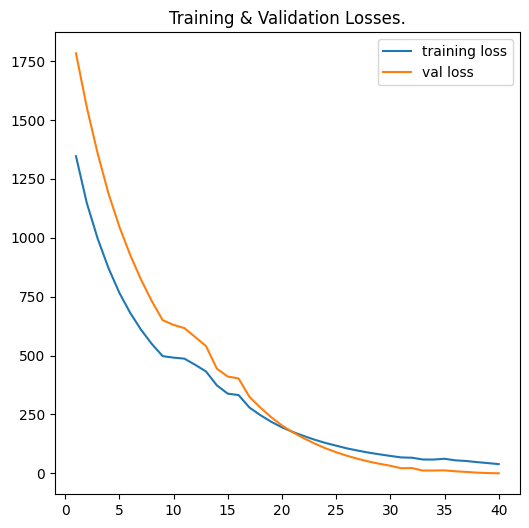

In [25]:
# plot losses and accuracies
fig, ax = plt.subplots(figsize=(6, 6))

# training
add_metric_plot(axes=ax,
                X=np.arange(1, len(train_losses)+1, 1),
                y=train_losses,
                legend="training loss",
                colour="C0")

# training
add_metric_plot(axes=ax,
                X=np.arange(1, len(val_losses)+1, 1),
                y=val_losses,
                legend="val loss",
                colour="C1")

# plot config
ax.set_title("Training & Validation Losses.", fontsize=12)
ax.legend(loc='best')

In [26]:
test_dataset = StormWindSpeedSequencedDataset(data_root_dir=DATA_ROOT_DIR,
                                              storms_to_exclude=[TEST_STORM], 
                                              storm_name=STORM_NAME,
                                              numeric_cols=NUMERIC_COLS,
                                              time_column=TIME_COLUMN,
                                              dt=DT,
                                              input_sequence_length=INPUT_SEQUENCE_LENGTH,
                                              target_length=TARGET_SEQUENCE_LENGTH,
                                              data_split="test",
                                              data_splits=DATA_SPLIT,
                                              transform=None,
                                              random_seed=SEED,
                                             )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)


print("\n\n\t\t#### TENSOR INFO ####\n")
print(f"\t --> Test Dataset: {test_dataset.__len__()} | dims: {test_dataset.data.shape}")



		#### TENSOR INFO ####

	 --> Test Dataset: 97 | dims: (97, 16)


In [27]:
preds, target = [], []

for _, batch_inputs, batch_targets in test_loader:    
    if NUM_FEATURES == 2:
        _test_input_speeds = batch_inputs[:, :, :]
    else:
        _test_input_speeds = batch_inputs[:, :, 1:]        

    _test_output = model(_test_input_speeds)

    preds.append(_test_output.item())
    target.append(batch_targets[:, :, 1].item())

assert len(preds) == test_dataset.__len__()

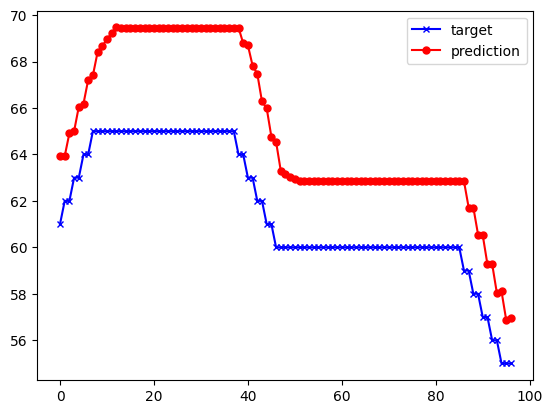

In [28]:
fig, ax = plt.subplots()

ax.plot(np.arange(test_dataset.__len__()), target, 'bx-', markersize=5, label='target')
ax.plot(np.arange(test_dataset.__len__()), preds, 'ro-', markersize=5, label='prediction')
ax.legend(loc="best")

### END OF SCRIPT